# A brief tutorial on using `lstbin` of `hera_cal`

Feb. 2018
<br>
Nick Kern
<br>
nkern@berkeley.edu

In this brief tutorial, we show you how to use the `lstbin` module of `hera_cal` on example HERA data. We will be using data from three nights of absolutely calibrated and RFI-flagged HERA-47 data, working only on a 7-element subset of the data. Each night contains three files worth of data, which amounts to 180 integrations per night (or 32.1 minutes per night). Details on the absolute calibration applied to the data can be found here: [HERA Memo 42](http://reionization.org/wp-content/uploads/2013/03/abscal_memo.pdf).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from pyuvdata import UVData, UVCal
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
from hera_cal.datacontainer import DataContainer
import aipy
import operator

# load and configure data

In [2]:
# load the data
night1 = sorted(glob.glob(os.path.join(DATA_PATH, "zen.2458043.4*.xx.HH.uvXRAA")))
night2 = sorted(glob.glob(os.path.join(DATA_PATH, "zen.2458044.4*.xx.HH.uvXRAA")))
night3 = sorted(glob.glob(os.path.join(DATA_PATH, "zen.2458045.4*.xx.HH.uvXRAA")))

uvd1 = UVData()
uvd1.read_miriad(night1)

uvd2 = UVData()
uvd2.read_miriad(night2)

uvd3 = UVData()
uvd3.read_miriad(night3)

# load data and meta data. LST arrays are the lst1, lst2, lst3 variables
data1, flgs1, ap1, a1, f1, t1, lst1, p1 = hc.abscal.UVData2AbsCalDict(uvd1, return_meta=True)
data2, flgs2, ap2, a2, f2, t2, lst2, p2 = hc.abscal.UVData2AbsCalDict(uvd2, return_meta=True)
data3, flgs3, ap3, a3, f3, t3, lst3, p3 = hc.abscal.UVData2AbsCalDict(uvd3, return_meta=True)

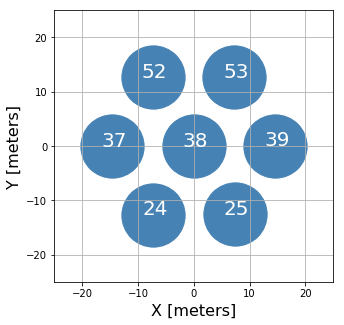

In [3]:
# plot array layout
antloc = np.array(ap1.values())
antloc -= np.median(antloc, axis=0)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid()
ax.scatter(antloc[:, 0], antloc[:, 1], s=4000, c='steelblue')
_ = [ax.text(antloc[i,0]-2, antloc[i,1], a1[i], fontsize=20, color='w') for i in range(len(a1))]
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.set_xlabel("X [meters]", fontsize=16)
ax.set_ylabel("Y [meters]", fontsize=16)

In [4]:
# form data list
data_list = [data1, data2, data3]
lst_list = [lst1, lst2, lst3]
flgs_list = [flgs1, flgs2, flgs3]

# get integration duration in radians
delta_lst = np.median(np.diff(lst1))

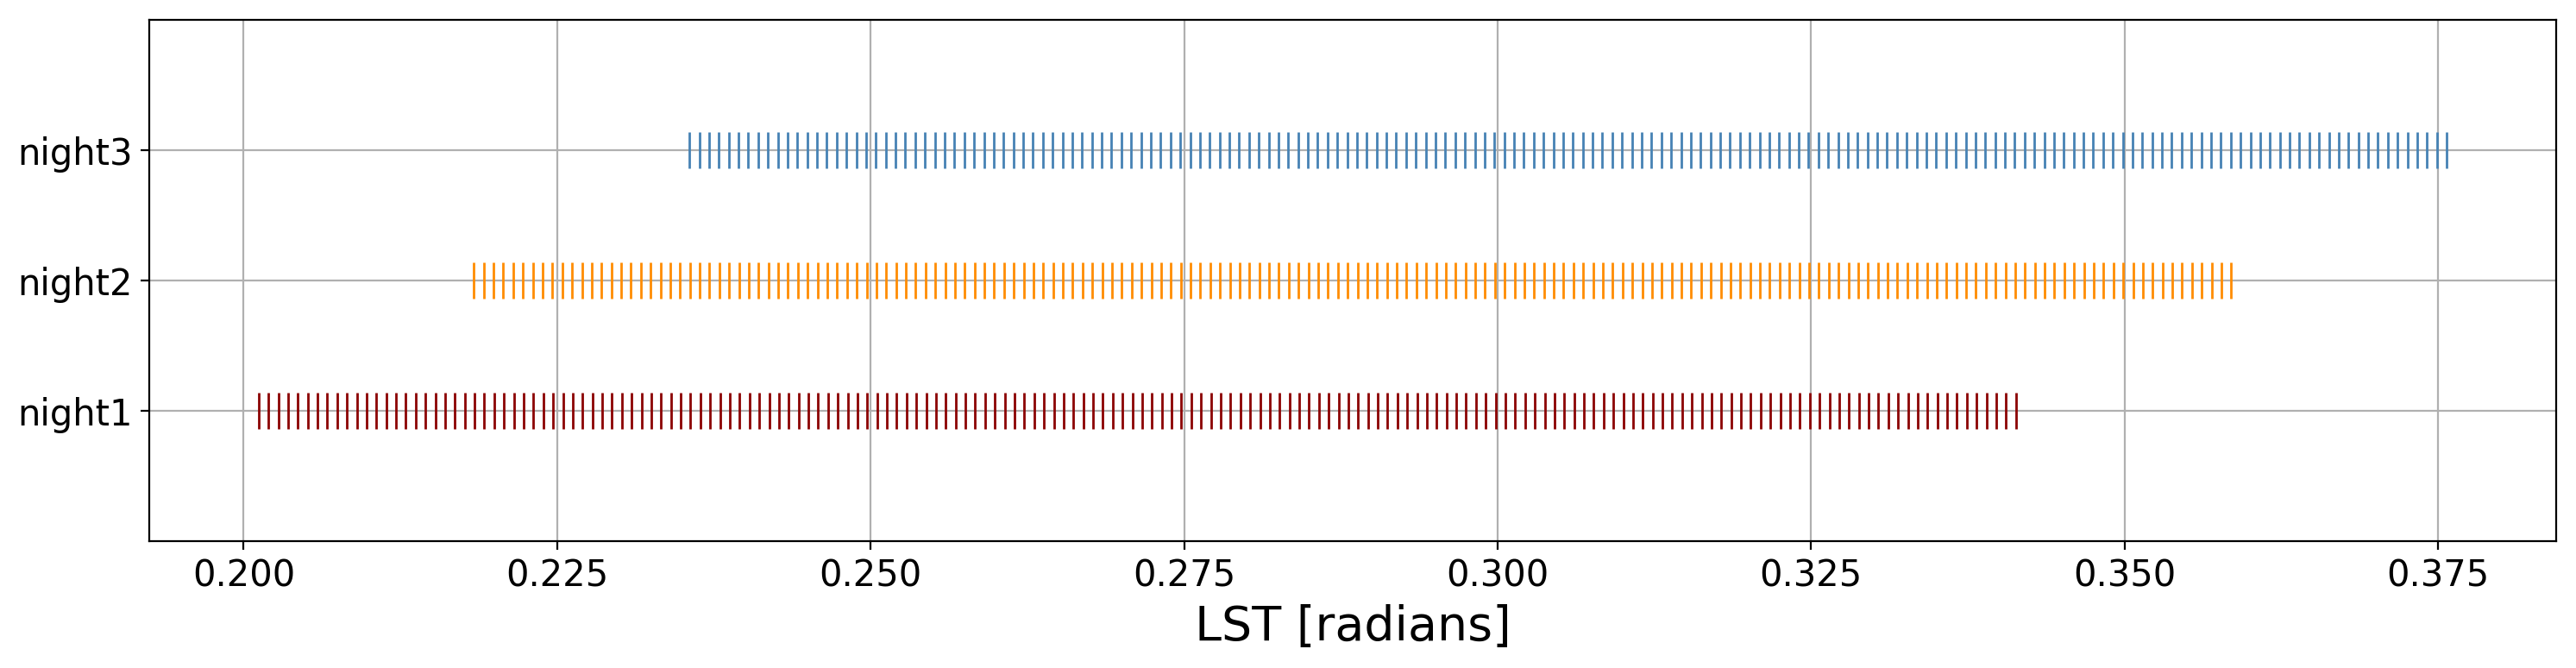

In [5]:
# plot the data's native LST integrations
fig, ax = plt.subplots(1, 1, figsize=(18, 4), dpi=200)
ax.grid()
p1, = ax.plot(lst1, np.ones_like(lst1)*0, color='darkred', ms=15, marker='|', ls='')
p2, = ax.plot(lst2, np.ones_like(lst2)*1, color='darkorange', ms=15, marker='|', ls='')
p3, = ax.plot(lst3, np.ones_like(lst3)*2, color='steelblue', ms=15, marker='|', ls='')
ax.set_ylim(-1, 3)
_ = [tl.set_size(15) for tl in ax.xaxis.get_ticklabels()]
ax.yaxis.set_ticks([0,1,2])
ax.yaxis.set_ticklabels(['night1', 'night2', 'night3'])
_ = [tl.set_size(15) for tl in ax.yaxis.get_ticklabels()]
ax.set_xlabel("LST [radians]", fontsize=20)

We can see from the figure above that the 32 minutes of data from each night do not align perfercly in LST. We see a drift in the LST duration for the data from night-to-night, corresponding to 4 minutes. Also more subtle is the fact that the integrations themselves do perfectly align across nights, even in the overlapping LST range.

# bin data with 10.7 second bin width

In the steps below, we will form a uniform LST grid and average the three nights of data that fall in each LST bin. We won't take into account the fact that the LST gridding of each night is 1) not aligned between nights and 2) not perfectly aligned with the LST bin itself.

In [6]:
# LST bin!
(lst_bins, data_avg, lst_flags, data_std,
 data_num) = hc.lstbin.lst_bin(data_list, lst_list, dlst=delta_lst, flags_list=flgs_list, flag_thresh=0.7)

2pi is not equally divisible by input dlst (0.0007829849626454) at 1 part in 1e5.
Using 0.0007830490163484 instead.


Mean of empty slice
Mean of empty slice
Degrees of freedom <= 0 for slice.


The `flag_thresh` parameter sets the fractional threshold of flagged data per bin at which point the entire bin is flagged.

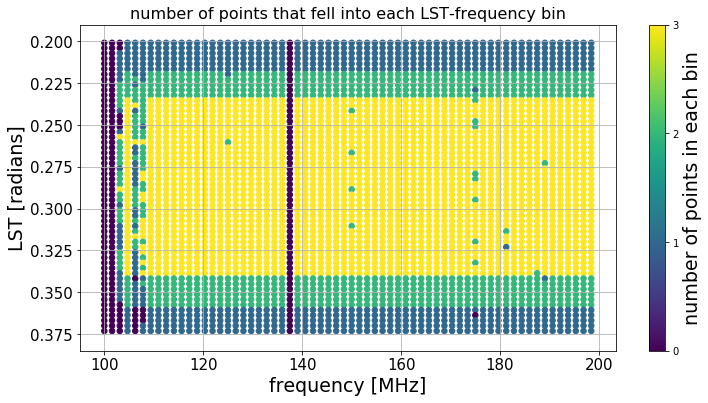

In [7]:
# plot the number of points that fell into each LST bin
key = data_num.keys()[0]
X, Y = np.meshgrid(np.linspace(100, 200, 64, endpoint=False), lst_bins[::4])
X = X.ravel()
Y = Y.ravel()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.grid()
cax = ax.scatter(X, Y, c=data_num[key][::4, :].ravel(), s=30, cmap='viridis')
cbar = fig.colorbar(cax)
cbar.set_ticks([0,1,2,3])
cbar.set_label('number of points in each bin', fontsize=19)
ax.set_xlabel('frequency [MHz]', fontsize=19)
ax.set_ylabel('LST [radians]', fontsize=19)
ax.set_ylim(0.385, 0.19)
_ = [tl.set_size(15) for tl in ax.get_xticklabels()]
_ = [tl.set_size(15) for tl in ax.get_yticklabels()]
ax.set_title("number of points that fell into each LST-frequency bin", fontsize=16)

Above we show the number of points that fell into each LST-frequency bin. This matches what we would have predicted given the previous figure, given the fact that we made an LST grid with the same time integration length as the data originally had. Below, we plot waterfalls from a 14.6 meter East-West baseline before and after LST binning, where we can see a slight reduction in noise by-eye after LST-binning. Keep in mind that the data in night1 on the left extends to only 160 integrations, while the plot on the right extends all the way to 224 integrations.

divide by zero encountered in log10
invalid value encountered in divide


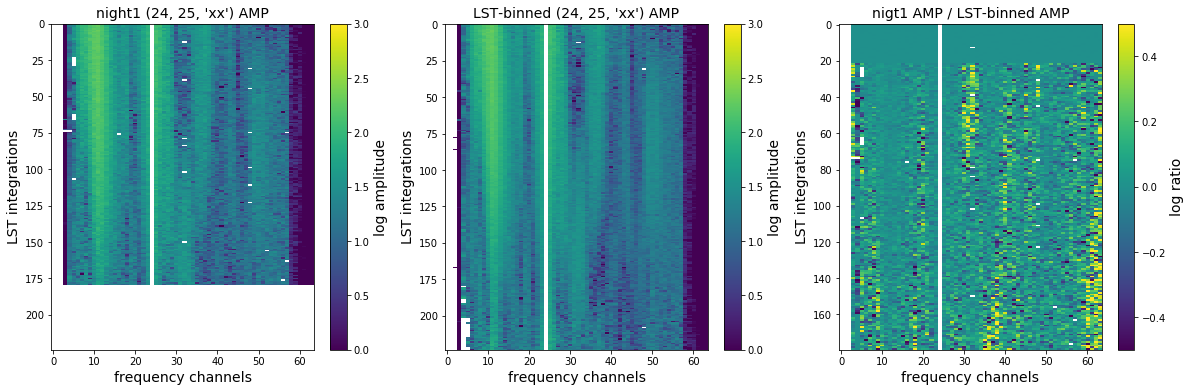

In [8]:
key = (24, 25, 'xx')
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

ax = axes[0]
plt.sca(ax)
_d = data1[key].copy()
_d[flgs1[key]] *= np.nan
uvt.plot.waterfall(_d, mode='log', mx=3, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('night1 {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)
ax.set_ylim(224, 0)

ax = axes[1]
plt.sca(ax)
_d2 = data_avg[key].copy()
_d2[lst_flags[key]] *= np.nan
uvt.plot.waterfall(_d2, mode='log', mx=3, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('LST-binned {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)

ax = axes[2]
plt.sca(ax)
uvt.plot.waterfall(_d/_d2[:180], mode='log', mx=0.5, drng=1)
cbar = plt.colorbar()
cbar.set_label('log ratio', fontsize=14)
ax.set_title('nigt1 AMP / LST-binned AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)

# bin data with sigma clipping

In this example, we will run a simple 1-iteration sigma clipping algorithm that will reject all points in each LST bin that lie outside of some sigma threshold. For this particular case, we will use a larger LST bin width to accumulate more points per LST bin. For the example, we choose to not LST align, although we could do this as well if we wanted. We will also choose a minimum number of points per LST-bin threshold in order to perform sigma clipping at 5 points. In other words, if an LST-bin contains 4 or less points, we won't perform sigma clipping. Note, sigma clipping slows down the code.

In [10]:
# form lst grid starting at 0 radians and going until 2*pi radians
lst_grid2 = hc.lstbin.make_lst_grid(delta_lst*4)
dlst2 = np.median(np.diff(lst_grid2))

2pi is not equally divisible by input dlst (0.0031319398505818) at 1 part in 1e5.
Using 0.0031321960653936 instead.


In [11]:
# introduce artifact into data
data1[(24, 25, 'xx')][25] *= 100
data1[(24, 25, 'xx')][70, 35:40] *= 100
data1[(24, 25, 'xx')][100:140, 32] *= 100
data1[(24, 25, 'xx')][120] *= 100

In [12]:
# LST bin, with 5 sigma rejection tolerance
(lst_bins, data_avg, flags_min, data_std, 
 data_num) = hc.lstbin.lst_bin(data_list, lst_list, flags_list=flgs_list, dlst=dlst2, sig_clip=True, sigma=5, min_N=5)

All-NaN slice encountered
invalid value encountered in greater
divide by zero encountered in divide
invalid value encountered in divide


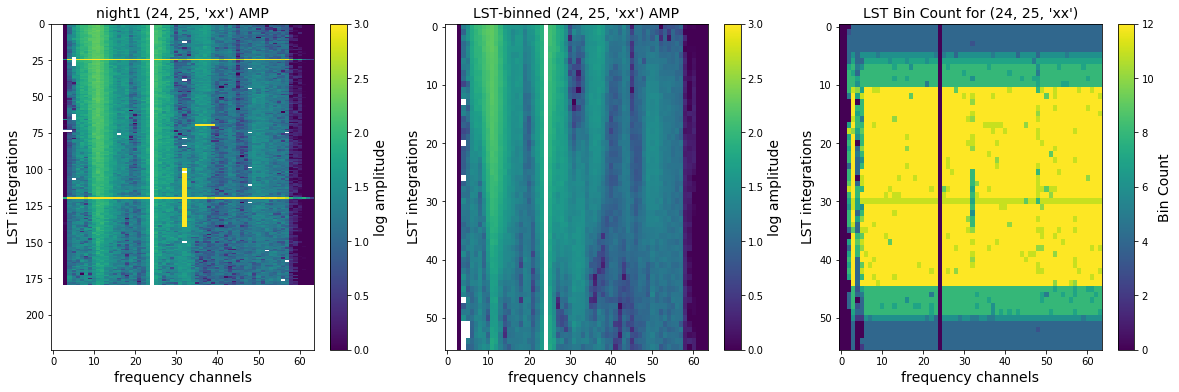

In [13]:
key = (24, 25, 'xx')
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

ax = axes[0]
plt.sca(ax)
_d = data1[key].copy()
_d[flgs1[key]] *= np.nan
uvt.plot.waterfall(_d, mode='log', mx=3, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('night1 {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)
ax.set_ylim(224, 0)

ax = axes[1]
plt.sca(ax)
_d = data_avg[key].copy()
_d[flags_min[key]] *= np.nan
uvt.plot.waterfall(_d, mode='log', mx=3, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('LST-binned {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)

ax = axes[2]
plt.sca(ax)
_d = data_num[key].copy()
uvt.plot.waterfall(_d, mode='real', mx=12, drng=12)
cbar = plt.colorbar()
cbar.set_label('Bin Count', fontsize=14)
ax.set_title('LST Bin Count for {}'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)

We can see that the artificial structure introduced in one file is not able to propagate to the LST binned data having sigma clipped before taking the average.

# run directly on the data files, write binned data to file

Here we will use the `lst_bin_files()` function of `lstbin` to run the LST binner directly on the data files in a way that minimizes file I/O.

In [5]:
# get data files
data_files = [sorted(glob.glob(DATA_PATH+'/zen.2458043.4*XRAA')),
              sorted(glob.glob(DATA_PATH+'/zen.2458044.4*XRAA')),
              sorted(glob.glob(DATA_PATH+'/zen.2458045.4*XRAA'))]

In [15]:
rm -r zen.xx.*

In [16]:
hc.lstbin.lst_bin_files(data_files, outdir='./', ntimes_per_file=100)

2pi is not equally divisible by input dlst (0.0007829849630919) at 1 part in 1e5.
Using 0.0007830490163484 instead.

LST file 1 / 3: 2018-02-17 19:45:23.526370
----------------------------------------


Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


saving ./zen.xx.LST.0.20164.uv
saving ./zen.xx.STD.0.20164.uv

LST file 2 / 3: 2018-02-17 19:45:37.159148
----------------------------------------
saving ./zen.xx.LST.0.27994.uv
saving ./zen.xx.STD.0.27994.uv

LST file 3 / 3: 2018-02-17 19:45:50.530104
----------------------------------------
saving ./zen.xx.LST.0.35824.uv
saving ./zen.xx.STD.0.35824.uv


In [17]:
rm -r ./zen.xx.*

# coherent integration tests

A required performance mark of the LST binning step is to show that we can indeed add data coherently such that thermal noise integrates down as the inverse square root of the number of samples per bin (i.e. $\propto N^{-1/2}$). To test this, we will perform a series of LST binning with different bin widths to get varying $N$ per bin. Our proxy for the thermal noise is simply the difference between adjacent time integrations for each frequency bin.

In [7]:
hc.lstbin.lst_bin_files(data_files, outdir='./', ntimes_per_file=250, dlst=delta_lst)

2pi is not equally divisible by input dlst (0.0007829849626454) at 1 part in 1e5.
Using 0.0007830490163484 instead.

LST file 1 / 1: 2018-02-17 19:53:56.936721
----------------------------------------


Mean of empty slice
Mean of empty slice
Degrees of freedom <= 0 for slice.
Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


saving ./zen.xx.LST.0.20164.uv
saving ./zen.xx.STD.0.20164.uv


In [8]:
hc.lstbin.lst_bin_files(data_files, outdir='./', ntimes_per_file=250, dlst=delta_lst*2)

2pi is not equally divisible by input dlst (0.0015659699252909) at 1 part in 1e5.
Using 0.0015660980326968 instead.

LST file 1 / 1: 2018-02-17 19:54:28.663680
----------------------------------------
saving ./zen.xx.LST.0.20124.uv
saving ./zen.xx.STD.0.20124.uv


In [9]:
hc.lstbin.lst_bin_files(data_files, outdir='./', ntimes_per_file=250, dlst=delta_lst*4)

2pi is not equally divisible by input dlst (0.0031319398505818) at 1 part in 1e5.
Using 0.0031321960653936 instead.

LST file 1 / 1: 2018-02-17 19:54:45.643225
----------------------------------------
saving ./zen.xx.LST.0.20203.uv
saving ./zen.xx.STD.0.20203.uv


In [10]:
# get raw data
uvd0 = UVData()
uvd0.read_miriad(night1)

# load first run
uvd1 = UVData()
uvd1.read_miriad('zen.xx.LST.0.20164.uv')

# load second run
uvd2 = UVData()
uvd2.read_miriad('zen.xx.LST.0.20124.uv')

# load third run
uvd3 = UVData()
uvd3.read_miriad('zen.xx.LST.0.20203.uv')

antenna_diameters is not set. Using known values for HERA.


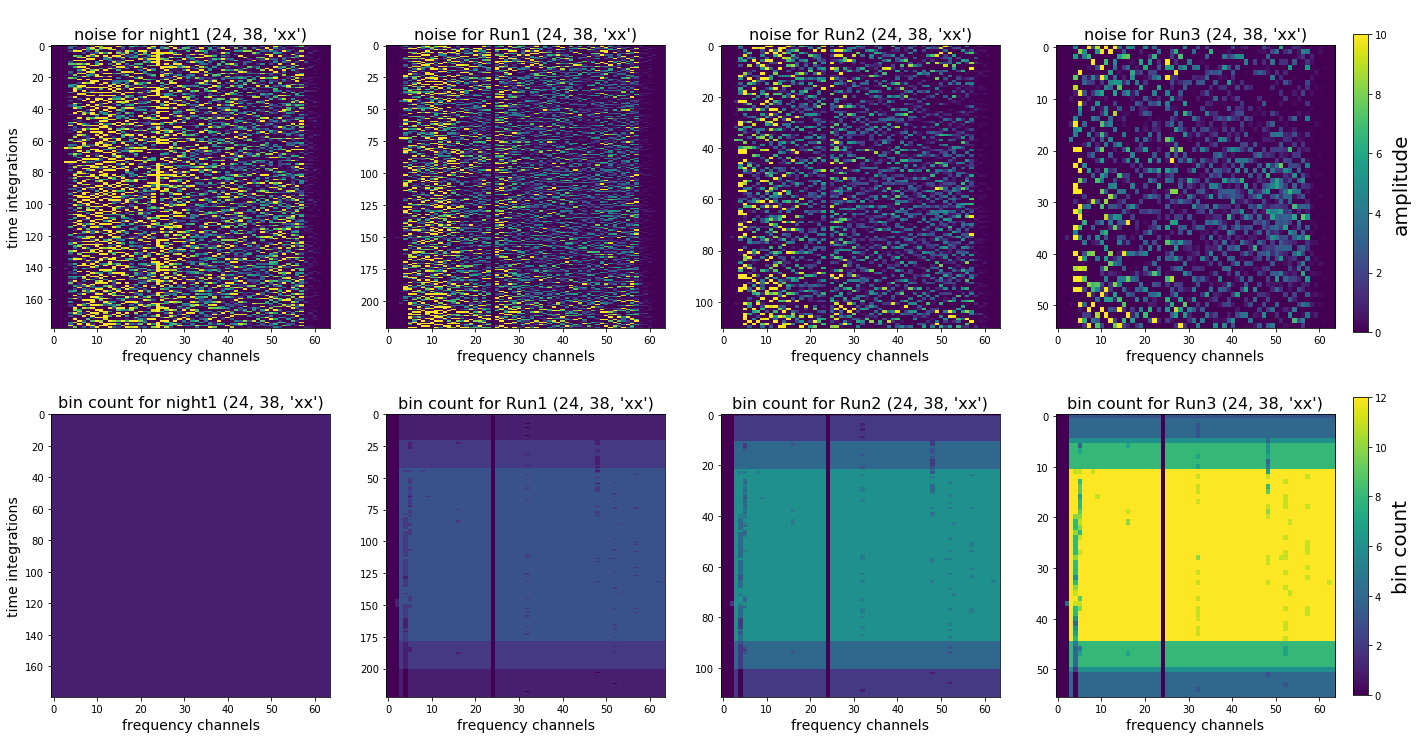

In [11]:
# plot thermal noise for a single baseline
key = (24, 38, 'xx')

d0 = uvd0.get_data(key)
n0 = np.diff(d0, axis=0)
c0 = uvd0.get_nsamples(key)
l0 = np.unique(uvd0.lst_array)[1:]

d1 = uvd1.get_data(key)
n1 = np.diff(d1, axis=0)
c1 = uvd1.get_nsamples(key)
l1 = np.unique(uvd1.lst_array)[1:]

d2 = uvd2.get_data(key)
n2 = np.diff(d2, axis=0)
c2 = uvd2.get_nsamples(key)
l2 = np.unique(uvd2.lst_array)[1:]

d3 = uvd3.get_data(key)
n3 = np.diff(d3, axis=0)
c3 = uvd3.get_nsamples(key)
l3 = np.unique(uvd3.lst_array)[1:]

fig, axes = plt.subplots(2, 4, figsize=(23, 12))
axes = axes.ravel()
fig.subplots_adjust(hspace=0.3)

ax = axes[0]
plt.sca(ax)
uvt.plot.waterfall(n0, mode='real', mx=10, drng=10)
ax.set_xlabel("frequency channels", fontsize=14)
ax.set_ylabel("time integrations", fontsize=14)
ax.set_title("noise for night1 {}".format(key), fontsize=16)

ax = axes[1]
plt.sca(ax)
uvt.plot.waterfall(n1, mode='real', mx=10, drng=10)
ax.set_xlabel("frequency channels", fontsize=14)
ax.set_title("noise for Run1 {}".format(key), fontsize=16)

ax = axes[2]
plt.sca(ax)
uvt.plot.waterfall(n2, mode='real', mx=10, drng=10)
ax.set_xlabel("frequency channels", fontsize=14)
ax.set_title("noise for Run2 {}".format(key), fontsize=16)

ax = axes[3]
plt.sca(ax)
cax = uvt.plot.waterfall(n3, mode='real', mx=10, drng=10)
ax.set_xlabel("frequency channels", fontsize=14)
ax.set_title("noise for Run3 {}".format(key), fontsize=16)

ax = fig.add_axes([0.86, 0.52, 0.06, 0.4])
ax.axis('off')
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label("amplitude", fontsize=20)

ax = axes[4]
plt.sca(ax)
uvt.plot.waterfall(c0, mode='real', mx=12, drng=12)
ax.set_xlabel("frequency channels", fontsize=14)
ax.set_ylabel("time integrations", fontsize=14)
ax.set_title("bin count for night1 {}".format(key), fontsize=16)

ax = axes[5]
plt.sca(ax)
uvt.plot.waterfall(c1, mode='real', mx=12, drng=12)
ax.set_xlabel("frequency channels", fontsize=14)
ax.set_title("bin count for Run1 {}".format(key), fontsize=16)

ax = axes[6]
plt.sca(ax)
uvt.plot.waterfall(c2, mode='real', mx=12, drng=12)
ax.set_xlabel("frequency channels", fontsize=14)
ax.set_title("bin count for Run2 {}".format(key), fontsize=16)

ax = axes[7]
plt.sca(ax)
cax = uvt.plot.waterfall(c3, mode='real', mx=12, drng=12)
ax.set_xlabel("frequency channels", fontsize=14)
ax.set_title("bin count for Run3 {}".format(key), fontsize=16)

ax = fig.add_axes([0.86, 0.1, 0.06, 0.4])
ax.axis('off')
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label("bin count", fontsize=20)

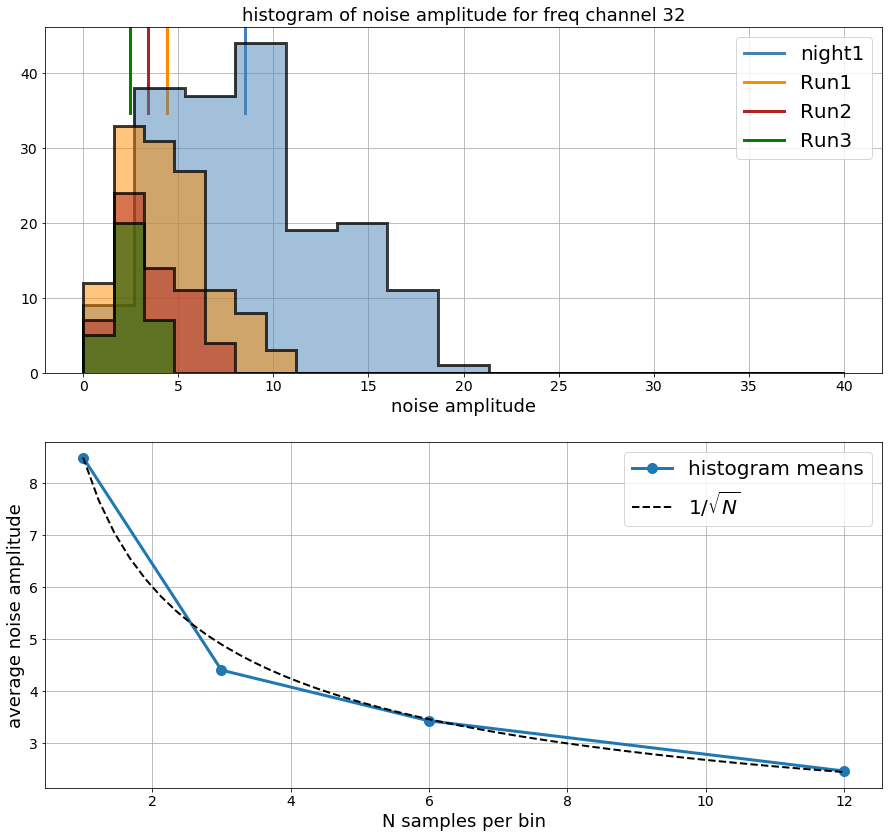

In [12]:
# plot a single frequency channel
f = 32
h0 = np.abs(n0[:, f])
h1 = np.abs(n1[50:175, f])
h2 = np.abs(n2[25:85, f])
h3 = np.abs(n3[11:43, f])
m0 = np.mean(h0)
m1 = np.mean(h1)
m2 = np.mean(h2)
m3 = np.mean(h3)
mc0 = np.median(c0[:, f])
mc1 = np.median(c1[50:175, f])
mc2 = np.median(c2[25:85, f])
mc3 = np.median(c3[11:43, f])

fig, axes = plt.subplots(2, 1, figsize=(15,14))

ax = axes[0]
ax.grid(zorder=0)
ax.set_xlabel("noise amplitude", fontsize=18)
ax.set_title("histogram of noise amplitude for freq channel {}".format(f), fontsize=18)
_ = [tl.set_size(14) for tl in ax.get_xticklabels()]
_ = [tl.set_size(14) for tl in ax.get_yticklabels()]

ax.hist(h0, bins=15, histtype='stepfilled', color='steelblue', lw=3, range=(0, 40), alpha=0.5, zorder=3)
ax.hist(h0, bins=15, histtype='step', color='k', lw=3, range=(0, 40), alpha=0.75, zorder=3)
ax.hist(h1, bins=25, histtype='stepfilled', color='darkorange', lw=3, range=(0, 40), alpha=0.5, zorder=3)
ax.hist(h1, bins=25, histtype='step', color='k', lw=3, range=(0, 40), alpha=0.75, zorder=3)
ax.hist(h2, bins=25, histtype='stepfilled', color='firebrick', lw=3, range=(0, 40), alpha=0.5, zorder=3)
ax.hist(h2, bins=25, histtype='step', color='k', lw=3, range=(0, 40), alpha=0.75, zorder=3)
ax.hist(h3, bins=25, histtype='stepfilled', color='green', lw=3, range=(0, 40), alpha=0.5, zorder=3)
ax.hist(h3, bins=25, histtype='step', color='k', lw=3, range=(0, 40), alpha=0.75, zorder=3)
p0 = ax.axvline(m0, color='steelblue', ymin=0.75, lw=3)
p1 = ax.axvline(m1, color='darkorange', ymin=0.75, lw=3)
p2 = ax.axvline(m2, color='firebrick', ymin=0.75, lw=3)
p3 = ax.axvline(m3, color='green', ymin=0.75, lw=3)
ax.legend([p0, p1, p2, p3], ["night1", "Run1", "Run2", "Run3"], fontsize=20)

ax = axes[1]
ax.grid(zorder=0)
ax.set_xlabel("N samples per bin", fontsize=18)
ax.set_ylabel("average noise amplitude", fontsize=18)
_ = [tl.set_size(14) for tl in ax.get_xticklabels()]
_ = [tl.set_size(14) for tl in ax.get_yticklabels()]

counts = np.array([mc0, mc1, mc2, mc3])
amps = np.array([m0, m1, m2, m3])
c_arr = np.linspace(1,12,50)
a_arr = amps[0] / np.sqrt(c_arr)

p0, = ax.plot(counts, amps, ls='-', marker='o', lw=3, markersize=10)
p1, = ax.plot(c_arr, a_arr, ls='--', color='k', lw=2)
ax.legend([p0, p1], ["histogram means", "$1/\sqrt{N}$"], fontsize=20)


In [27]:
rm -r ./zen.xx.*